## Kaytoo | Inference & Model Evaluation Notebook

### Bird Call Classification for New Zealand 

This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into both this and my inference `.py` script whilst only having to maintain a single copy of them.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [1]:
notebook_use = {
                'project_root': 'E:\Kaytoo',  #For Calculon "E:\Kaytoo" 
                #'project_root': '/media/olly/T7/Kaytoo',   #For Alita & Selene  
                'experiment': 6,
                'bird_name_csv': 'Data/Experiments/Exp_6/Results/exp_6_bird_map.csv',
                'folder_to_process': 'Data/Soundscapes/DOC_Tier1_2011/',
                'model_choices': [0],
                'cpu_only': False,
                'num_cores': 1  #Can crank this up if using CPU only.
                }

## Imports

In [2]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from bird_naming_utils import BirdNamer
from IPython.display import Image, display

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#Machine Learning 
import albumentations as A

#Torch and PyTorch specific
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import  DataLoader, Dataset
from torchaudio.functional import compute_deltas

#Audio
import librosa
import torchaudio
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [3]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu_only']:
                self.device = torch.device('cpu')
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1

        self.classes = bird_namer.bird_list

In [4]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [5]:
class ModelParameters:
   def __init__(self, options=None):
        self.parameters = [
        {'basename':'tf_efficientnet_b0.ns_jft_in1k',  #Exp_116 LB66, 43 minutes, uses Googlebirds_25 for 7 epochs
                         #'ckpt_path': '/media/olly/T7/Kaytoo/Data/Experiments/Exp_2/Results/epoch=12-step=68337.ckpt',
                         'ckpt_path': "E:\Kaytoo\Data\Experiments\Exp_6\Results\epoch=13-step=109788.ckpt",
                         'image_shape': (1,2), #The layout of 5-sec spectrograms stacked into the final image (height x width)
                         'image_time': 10,
                         'n_mels': 256,
                         'n_fft': 2048,
                         'use_deltas' : True,
                         'hop_length': 1243,
                         '5_sec_width': 128,
                         'aggregation': 'mean',
                         }, 
        ]
        if options and options.get('model_choice'):
            model_choices = options['model_choice']
            _parameters_list = [_parameters_list[i] for i in model_choices] 

In [6]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.predictions_csv = self.soundscapes_folder / 'predictions.csv'
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'

## Helper Functions

In [7]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'


def open_audio_clip(path, default_sr = 32000):   
    #Modify this to re-sample anything not using 32,000 sample rate
    try:  
        y, sr = torchaudio.load(path)
        if y.ndim == 2 and y.shape[0] == 2:
            y = torch.mean(y, dim=0).unsqueeze(0)  # from stereo to mono
        y = y.squeeze().numpy() 
    except:
        y = np.random.randn(5*default_sr)
        sr = default_sr 
        print(f'could not open {path}')

    if sr != default_sr:
        num_samples = int(len(y) * default_sr / sr)
        y = resample(y, num_samples)
    
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    return y


def compute_melspec(y, sr, hop_length, n_mels, n_fft, audio_params):
    if audio_params:
        fmin = audio_params.FMIN
        fmax = audio_params.FMAX
    else:
        fmin = 40
        fmax = 14000

    melspec = librosa.feature.melspectrogram(y=y, 
                                             sr=sr, 
                                             n_mels=n_mels, 
                                             n_fft=n_fft, 
                                             hop_length = hop_length, 
                                             fmin=fmin, 
                                             fmax=fmax
                                            ) 
    return librosa.power_to_db(melspec)


class PrepareImage():
    mean = .5
    std = .22
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.prep = A.Compose([
            A.PadIfNeeded(min_height=self.height, min_width=self.width),
            A.CenterCrop(width=self.width, height=self.height),
            A.Normalize(mean=self.mean, std=self.std, max_pixel_value=1.0, always_apply=True),
        ])


def get_images(audio_path, #PathLib Path object
               model_params,
               audio_params,
               clip_length=None,
               sr=32000):
    
    hop_length = model_params['hop_length']
    n_mels = model_params['n_mels']
    n_fft = model_params['n_fft']
    chunk_width = model_params['5_sec_width']
    num_chunks = model_params['image_shape'][0] * model_params['image_shape'][1]
    chunk_length = model_params['image_time']//(num_chunks)
    prep_image = PrepareImage(height=n_mels, width=chunk_width)


    idxs  = []
    image_dict = {}
    _y = open_audio_clip(audio_path)
    if clip_length is None:
        clip_length = len(_y) // sr

    for index in range(0, clip_length // chunk_length):
        idxs.append(index)
        start = index * chunk_length
        stop = start + chunk_length
        start_idx = sr * start
        stop_idx =  sr * stop
        
        if stop_idx > len(_y):
            y = _y[start_idx:]
            remaining_length = stop_idx - len(_y)  # Calculate how much we need to fill
            noise = np.random.randn(remaining_length) * np.std(_y)
            y = np.concatenate((y, noise))
        else: 
            y = _y[start_idx: stop_idx]
        
        max_vol = np.abs(y).max()
        y = y * 1 / max_vol    #y, sr, hop_length, n_mels, n_fft, audio_params
        image = compute_melspec(y, sr, hop_length, n_mels, n_fft, audio_params)
        image = prep_image.prep(image=image)['image']
        image_dict[index] = image
        
    num_specs = len(image_dict)
    extra_specs = clip_length % num_chunks  #Handle the case where there are more spectrograms needed to make up the combined image
    if extra_specs:
        noise = np.random.randn(chunk_length * sr)
        image = compute_melspec(noise, sr, hop_length, n_mels, n_fft, audio_params)
        image = prep_image.prep(image=image)['image']
        for extra_idx in range(num_specs+1, num_specs+extra_specs+1):
            image_dict[extra_idx] = image

    return image_dict, extra_specs  #a dict of images, with keys from 0 to 47 for the case of a 240 second clip.

In [8]:
def mono_to_color(X, eps=1e-6, use_deltas=False):
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales to a range of [0,1]
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    
    if use_deltas:
        T = torch.tensor(X, dtype=torch.float32)
        delta = compute_deltas(T)
        delta_2 = compute_deltas(delta)
        delta, delta_2 = delta.numpy(), delta_2.numpy()
        X=np.stack([X, delta, delta_2], axis=-1)
    else:
        X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image

    return X


def crop_or_pad(y, length, train='train'):
    y = np.concatenate([y, y, y])
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if train != 'train':
            start = 0
        else:
            start = np.random.randint(len(y) - length)
        y = y[start: start + length]
    return y
      

def show_batch(img_ds, model_args, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, _ = img_ds[index]  #returns an image of n chunks
        shape=img.shape
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, 
                                       x_axis='time', 
                                       y_axis='mel', 
                                       sr=32000, 
                                       n_fft=model_args['n_fft'] * model_args['image_shape'][0],
                                       hop_length=model_args['hop_length'],
                                       ax=ax)
        ax.set(title=f'Loading Index {index}, shape: {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")    

## Augmentation Classes

In [9]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y
    

class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError
    
    
class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)
    

class AbluTransforms():
    mean = (0.485, 0.456, 0.406) # RGB
    std = (0.229, 0.224, 0.225) # RGB
    
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.valid = A.Compose([
                        A.PadIfNeeded(min_height=self.height, min_width=self.width),
                        A.CenterCrop(width=self.width, height=self.height),
                        A.Normalize(self.mean, self.std, max_pixel_value=1.0,always_apply=True),
                        ])

## Dataset Definition

In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_dict, image_shape, use_deltas): #, model_args
        self.image_dict = image_dict
        self.image_shape = image_shape
        self.image_pixels = self.image_dict[0].shape
        self.height = self.image_shape[0] * self.image_pixels[0]  #Shape of the combined image from one __get_item__
        self.width = self.image_shape[1] * self.image_pixels[1] 
        self.image_transform = AbluTransforms(height=self.height, width=self.width).valid
        self.use_deltas = use_deltas
        self.chunks_per_image = self.image_shape[0] * self.image_shape[1]
               
    def __len__(self):
        whole = len(self.image_dict) // self.chunks_per_image
        remainder =  1 if len(self.image_dict) % self.chunks_per_image != 0 else 0
        return  whole + remainder

    def __getitem__(self, idx):
        base = idx * self.chunks_per_image
        chunk_idxs = [base + n for n in range(self.chunks_per_image)]
        images = [self.image_dict[img_id] for img_id in chunk_idxs]
        
        if self.image_shape == (2,2):  #The (2,2) case 
            image = np.vstack((np.hstack((images[0], images[1])),   
                               np.hstack((images[2], images[3]))))
        elif self.image_shape == (1,2):  
            image = np.hstack((images[0], images[1]))
        elif self.image_shape == (2,1): 
            image = np.vstack((images[0], images[1]))
        elif self.image_shape == (1,4):
            image = np.hstack((images[0], images[1], images[2], images[3]))
        else:
            image = images[0]

        image = mono_to_color(image, use_deltas=self.use_deltas)
        image = self.image_transform(image=image)['image']
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        return image, idx

## Model Definition

In [11]:
class BirdSoundModel(pl.LightningModule):

    def init_layer(self, layer):
        nn.init.xavier_uniform_(layer.weight)
        if hasattr(layer, "bias"):
            if layer.bias is not None:
                layer.bias.data.fill_(0.)

    def init_bn(self, bn):
        bn.bias.data.fill_(0.)
        bn.weight.data.fill_(1.0)
        
    def init_weight(self):
        self.init_bn(self.bn0)
        self.init_layer(self.fc1)


    class AttentionBlock(nn.Module):
        def __init__(self,
                     in_features: int,
                     out_features: int,
                     shape:tuple,
                     activation="linear",
                     aggregation='mean',
                    ):
            super().__init__()

            self.activation = activation
            self.attention = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.classify = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.init_weights()
            self.chunks_high = shape[0]
            self.chunks_wide = shape[1]
            self.num_chunks = shape[0] * shape[1]
            self.aggregation = aggregation
        
        def init_layer(self, layer): #could access the outer class init_layer method instead
            nn.init.xavier_uniform_(layer.weight)
            if hasattr(layer, "bias"):
                if layer.bias is not None:
                    layer.bias.data.fill_(0.)
               
        def init_weights(self):
            self.init_layer(self.attention)
            self.init_layer(self.classify)

        def nonlinear_transform(self, x):
            if self.activation == 'linear':
                return x
            elif self.activation == 'sigmoid':
                return torch.sigmoid(x)

        def forward(self, x):
            batch_size = x.shape[0]
            split_length = x.shape[2] // self.num_chunks  #The number of segments per 5 sec time chunk
            splits = torch.split(x, split_length, dim=2)
            x = torch.cat(splits, dim=0)
            
            norm_att = torch.softmax(torch.tanh(self.attention(x)), dim=-1) / (16//split_length)  # /4 or 2 or 1 so the 16 values sum to 1
            classify_logits = self.classify(x) 
            logits_with_attn  = norm_att * classify_logits * self.num_chunks
            

            if self.aggregation == 'mean':
                chunk_preds = self.nonlinear_transform(logits_with_attn.sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            elif self.aggregation == 'mean-max':
                chunk_preds = self.nonlinear_transform((logits_with_attn * self.num_chunks).sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds_mean = torch.cat(chunk_splits, dim=2)
                
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds_max = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
                
                chunk_preds = (chunk_preds_mean + chunk_preds_max) / 2
            
            elif self.aggregation =='max':
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            chunk_preds = chunk_preds.transpose(1,2) #Putting the class predictions last
            chunk_preds = chunk_preds.reshape(chunk_preds.shape[0]*chunk_preds.shape[1], -1)  #flatten to (num_preds,num_classes)
                        
            return chunk_preds

    
    def __init__(self, 
                 classes, 
                 kwargs,
                 in_channels=3,
                ):
        super().__init__()
        
        self.image_time = kwargs['image_time'] # The total length of time represented by one complete image
        self.spec_height = kwargs['n_mels'] # The height of each spectrogram, before any stacking into an image
        self.chunk_width = kwargs['5_sec_width'] # The width of each spectrogram, before any stacking into an image
        self.image_shape = kwargs['image_shape'] # The spectrogram arrangement into an image (2,2) or (1,1) or (1,2), height x width
        self.base_model_name = kwargs['basename']
        self.aggregation = kwargs['aggregation']
        self.classes = classes
        self.num_classes = len(classes)
        
        self.image_width = self.image_shape[1] * self.chunk_width
        self.bn0 = nn.BatchNorm2d(self.image_width)   #self.image_width  #why is this still 256???
        
        self.base_model = timm.create_model(
                                    self.base_model_name, 
                                    pretrained=False, 
                                    in_chans=in_channels,
                                    )
        layers = list(self.base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(self.base_model, "fc"):
            in_features = self.base_model.fc.in_features
        elif self.base_model_name == 'eca_nfnet_l0':
            in_features = self.base_model.head.fc.in_features
        elif self.base_model_name == 'convnext_tiny.in12k_ft_in1k':
            in_features = self.base_model.head.fc.in_features
        else:
            in_features = self.base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = self.AttentionBlock(in_features, 
                                            self.num_classes,
                                            self.image_shape,
                                            activation="sigmoid",
                                            aggregation = self.aggregation,
                                            )
        self.init_weight()
        self.val_outputs = []
        self.train_outputs = []
        self.metrics_list = []
        self.val_epoch = 0
        

    def forward(self, input_data):
        x = input_data  #(batch_size, 3, frequency, time)  #This needs to match the the output of dataloader & getitem 
        x = x.transpose(1, 3)  #(batch_size, mel_bins, time_steps, channels)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        x = self.encoder(x)  #This is the image passing through the base model  8x8 out with a 256x256 original image
        
        if self.image_shape == (2,2):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            half = x.shape[2]//2
            x0 = x[:,:,:half,:half]
            x1 = x[:,:,:half,half:]
            x2 = x[:,:,half:,:half]
            x3 = x[:,:,half:,half:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,4):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            quarter = x.shape[2]//4
            x0 = x[:,:,:,:quarter]
            x1 = x[:,:,:,quarter:2*quarter]
            x2 = x[:,:,:,2*quarter:3*quarter]
            x3 = x[:,:,:,3*quarter:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,2):
            half = x.shape[3]//2
            x0 = x[:,:,:,:half]
            x1 = x[:,:,:,half:]
            x = torch.cat((x0,x1), dim=2) #For a 128x128 (2,1) image, we'd now have 8 high in frequency, 2 wide in time
        
        #This is the guts of the SED part.
        x = torch.mean(x, dim=3) # Aggregate in the horizontal (time) axis, so now we've just got a 3d tensor (batch_size, n_features, freq-time chunks)       
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        
        chunk_preds = self.att_block(x)
        #print(chunk_preds.shape)
        return chunk_preds #(48,182) regardless of how the images were shaped

In [12]:
class Models:
    def __init__(self, config, model_parameters, audio_parameters):
        self.args_list = model_parameters.parameters
        self.audio = audio_parameters
        self.ebirds = config.classes
        self.device = config.device

    def get_model(self, idx):
        model_args = self.args_list[idx]
        path = model_args['ckpt_path']
        map_location = 'cpu' if self.device == torch.device('cpu') else 'cuda'
        ckpt = torch.load(path, map_location=map_location)
        model = BirdSoundModel(self.ebirds, model_args)
        model.load_state_dict(ckpt)
        model.eval()
        model.parameters = self.args_list[idx]
        model.audio = self.audio
        model.to(self.device)
        return model  

## Inference Functions

In [13]:
def prediction_for_clip(audio_path,
                        model,
                        sub_process=False):
    model_args=model.parameters
    audio_params=model.audio
    device = model.device 
    
    image_dict, num_extras = get_images(audio_path, model_args, audio_params)
    num_images = len(image_dict)
    dataset = ImageDataset(image_dict, model_args['image_shape'], model_args['use_deltas'])
    shape = model_args['image_shape']
    num_chunks = shape[0] * shape[1]
    batch_size = num_images // num_chunks  #should be a whole number, because we made sure of this in the get_images
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    if not sub_process:
        progress = tqdm(range(len(loader)), desc="Inferring a single soundscape")
    
    for images, _ in loader:
        images=images.to(device)

        with torch.no_grad():
            predictions = model(images)  
            batch_segment_preds = predictions.detach().cpu().numpy()  #batch_size x num_chunks x num_classes
      
        if not sub_process:
            progress.update(1)

    del loader, dataset, image_dict
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()

    #Now let's lop off the last num_extras predictions, as these were made on place-holding random noise
    if num_extras:
        batch_segment_preds = batch_segment_preds[:-num_extras, :]

    return batch_segment_preds


def process_clip(audio_path, model):
    clip_preds = []
    final_row_ids = []
    batch_preds = prediction_for_clip(audio_path,
                                      model,
                                      sub_process=True)
    
    num_preds = batch_preds.shape[0]
    
    for idx in range(num_preds):
        row = batch_preds[idx]
        clip_preds.append(row)
    
    row_ids = [audio_path.stem + f'_{end}' for end in range(5, (num_preds+1)*5, 5)]
    final_row_ids.extend(row_ids)

    return clip_preds, final_row_ids


def inference(test_audios, models, model_idx, cores=1):
    bird_list = models.ebirds
    model = models.get_model(model_idx)
    results = Parallel(n_jobs=cores)(
        delayed(process_clip)(audio_path, model=model) for audio_path in tqdm(test_audios, desc="Overall File List")
        )
    
    del model
    if models.device == torch.device('cuda'):
        torch.cuda.empty_cache()

    clip_preds = [result[0] for result in results]      #This should be a list of 1 x num_classes arrays, with a length = the number of predictions
    final_row_ids = [result[1] for result in results]   #This should be a list of row id's?

    clip_preds = [item for sublist in clip_preds for item in sublist]
    final_row_ids = [item for sublist in final_row_ids for item in sublist]
    prediction_df = pd.DataFrame(clip_preds, columns=bird_list)
    prediction_df.insert(0, 'row_id', final_row_ids)
    
    return prediction_df

## Initialise

In [14]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)
parameters = ModelParameters(options=notebook_use)
models = Models(config=cfg, 
                model_parameters=parameters, 
                audio_parameters=audio)

print('The inference folder is:', paths.soundscapes_folder)
print(f'There are {len(models.args_list)} model(s) to be ensembled')
print(f'The model(s) will predict the following {len(models.ebirds)} birds (referring to their https://ebird.org code): \n')
for i in range(0, len(models.ebirds), 10):
    print(", ".join(models.ebirds[i:i + 10]))

The inference folder is: E:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011
There are 1 model(s) to be ensembled
The model(s) will predict the following 87 birds (referring to their https://ebird.org code): 

ausbit1, ausmag2, auspip3, aussho1, baicra4, blbgul1, blfter1, blkswa, bluduc1, calqua
cangoo, caster1, charob1, chiger2, chukar, codpet1, comcha, commyn, compea, comred
coopet, dobplo1, dunnoc1, easros1, eurbla, eurgol, eurgre1, eursta, fernbi1, gretea1
grskiw1, gryger1, houspa, kea1, kelgul, kokako3, larus, liskiw1, litowl1, litpen1
lotkoe1, mallar3, maslap1, morepo2, motpet, nezbel1, nezfal1, nezfan1, nezkak1, nezpig2
nezrob2, nezrob3, nibkiw1, okbkiw1, oyster1, parake, parpet1, parshe1, piesti1, pipipi1
purswa6, rebgul1, redjun1, riflem1, rinphe1, sackin1, saddle2, shbcuc1, silver3, skylar
sobkiw2, soiwre1, sonthr1, spocra1, spocra2, swahar1, takahe3, tomtit1, tui1, weka1
welswa1, weta, whfter1, whiteh1, x00458, yellow2, yellow3


In [15]:
print('\nThe first three recordings to be precessed are:')
for i in range(min(3, len(paths.soundscapes))):
    print(paths.soundscapes[i])

print('\nThe parameters for the first model are:')
for parameter, value in models.args_list[0].items():
    print(f'{parameter}: {value}')


The first three recordings to be precessed are:
E:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
E:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav
E:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav

The parameters for the first model are:
basename: tf_efficientnet_b0.ns_jft_in1k
ckpt_path: E:\Kaytoo\Data\Experiments\Exp_6\Results\epoch=13-step=109788.ckpt
image_shape: (1, 2)
image_time: 10
n_mels: 256
n_fft: 2048
use_deltas: True
hop_length: 1243
5_sec_width: 128
aggregation: mean


## Varify on a Single Soundscape

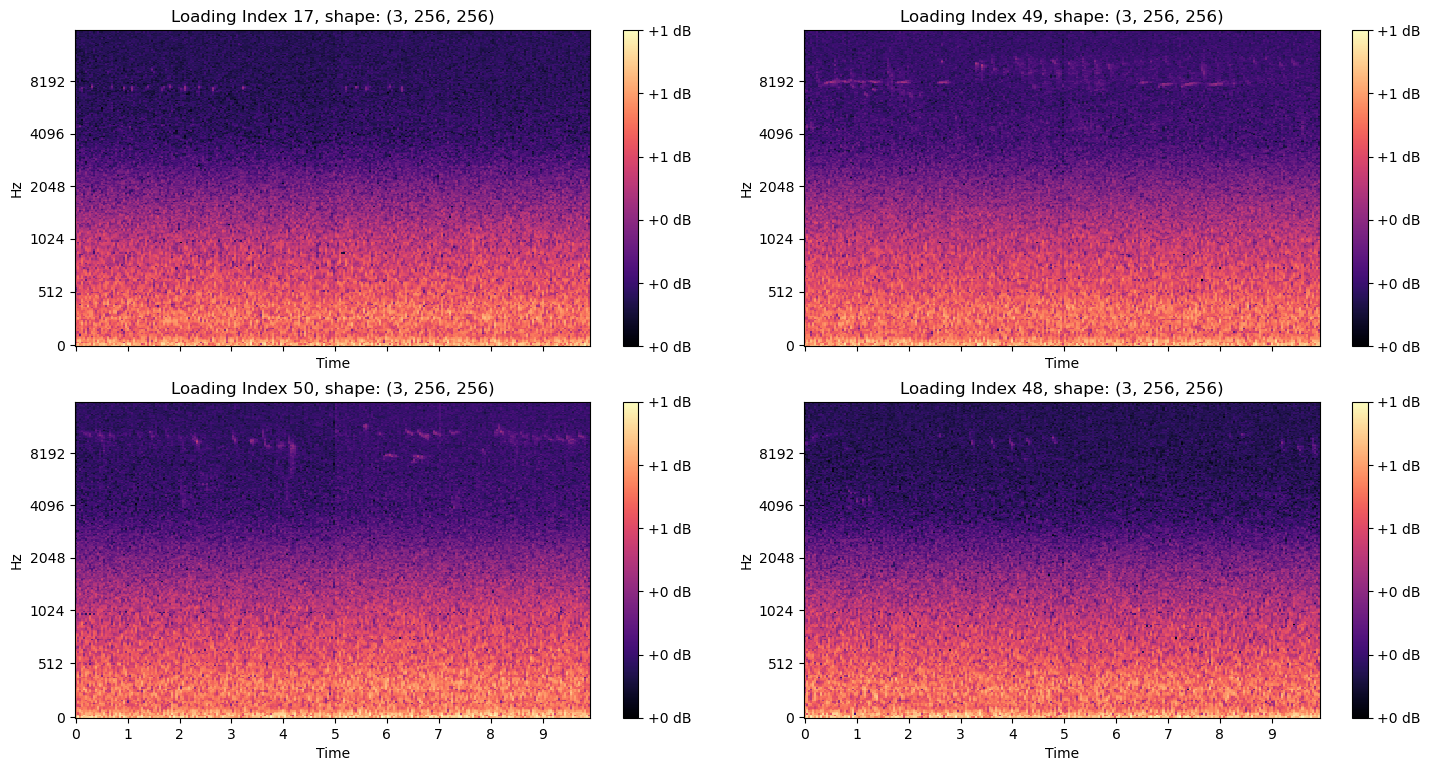

In [16]:
soundscape = random.choice(paths.soundscapes)
image_dict, num_extras = get_images(soundscape, models.args_list[0], audio_params=models.audio)
image_shape = models.args_list[0]['image_shape']
use_deltas = models.args_list[0]['use_deltas']
dataset = ImageDataset(image_dict, image_shape, use_deltas)
show_batch(dataset, models.args_list[0], 2,2)

In [17]:
model = models.get_model(0)
#clip_prediction = prediction_for_clip(random.choice(paths.soundscapes), model)
#print(f'The shape of the clip predictions array is {clip_prediction.shape}')

## Prediction in 5 second intervals

In [18]:
test_audios = paths.soundscapes #[:2]

In [19]:
prediction_dfs = []
#Note: There is an inherent inefficiency here if using models that share the same spectrograms, as spectrogram generation is repeated for each model.
#My assumption was that different models in any ensemble I make will be based on different spectrogram parameters
for idx in range(len(models.args_list)):
    df = inference(test_audios, models, idx, cores=cfg.CORES)
    prediction_dfs.append(df)

Overall File List:   0%|          | 0/39 [00:00<?, ?it/s]

Average the various prediction dataframes

In [20]:
prediction_columns = prediction_dfs[0].columns[1:]
values_list = [df[prediction_columns].values for df in prediction_dfs]
average_vals = np.zeros_like(values_list[0])

for array in values_list:
    average_vals = average_vals + array 

average_vals = average_vals / len(values_list)
submission = pd.DataFrame(data=average_vals, columns=prediction_columns)
submission.insert(0, 'row_id', prediction_dfs[0]['row_id']) 

In [21]:
submission.to_csv(paths.predictions_csv, index=False)

In [22]:
pd.read_csv(paths.predictions_csv)

,row_id,ausbit1,ausmag2,auspip3,aussho1,baicra4,blbgul1,blfter1,blkswa,bluduc1,...,tomtit1,tui1,weka1,welswa1,weta,whfter1,whiteh1,x00458,yellow2,yellow3
0,AE142_BIRD_120321_085925_5,0.001705,0.005866,0.008751,0.000090,0.000135,0.000216,0.000173,0.000475,0.000182,...,0.402247,0.159868,0.029616,0.000102,0.010744,0.000184,0.031173,0.000592,0.013864,0.005491
1,AE142_BIRD_120321_085925_10,0.001952,0.006891,0.008577,0.000155,0.000159,0.000265,0.000236,0.000642,0.000195,...,0.439348,0.155208,0.032415,0.000152,0.014298,0.000218,0.030260,0.000632,0.015444,0.007444
2,AE142_BIRD_120321_085925_15,0.000493,0.007777,0.011890,0.000036,0.000638,0.000056,0.000658,0.000120,0.000053,...,0.209212,0.207318,0.020976,0.000071,0.014439,0.000053,0.022194,0.001352,0.016581,0.001332
3,AE142_BIRD_120321_085925_20,0.000438,0.006451,0.011195,0.000031,0.000541,0.000043,0.000631,0.000082,0.000030,...,0.194952,0.201371,0.016288,0.000061,0.014099,0.000039,0.020609,0.001087,0.016108,0.000934
4,AE142_BIRD_120321_085925_25,0.001525,0.010018,0.009525,0.000429,0.002016,0.000311,0.001894,0.000546,0.000131,...,0.297003,0.158978,0.016417,0.000326,0.018212,0.000506,0.045801,0.001514,0.015813,0.007684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015,AV125_BIRD_120204_085925_880,0.085729,0.043807,0.076853,0.005453,0.041922,0.009455,0.005750,0.010504,0.030805,...,0.271198,0.108185,0.088505,0.005658,0.070520,0.006260,0.051843,0.012737,0.060488,0.084585
7016,AV125_BIRD_120204_085925_885,0.000342,0.003095,0.002020,0.000015,0.000189,0.001245,0.000094,0.000740,0.000580,...,0.113041,0.575264,0.049827,0.000035,0.018002,0.000300,0.007480,0.000677,0.004220,0.000597
7017,AV125_BIRD_120204_085925_890,0.000099,0.002288,0.001093,0.000003,0.000047,0.000490,0.000019,0.000323,0.000112,...,0.104366,0.672018,0.027130,0.000008,0.014645,0.000060,0.004461,0.000219,0.002308,0.000193
7018,AV125_BIRD_120204_085925_895,0.009545,0.016277,0.028846,0.000537,0.004004,0.001240,0.001696,0.001212,0.001881,...,0.280070,0.148891,0.087323,0.000456,0.030011,0.002565,0.022445,0.002785,0.026905,0.018309


## Analysis of Training Metrics

### Class Sizes and Distributions

First lets look at the classes and their sizes.

In [23]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(45)

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
0,Spotless Crake,spocra2,Zapornia tabuensis,Crake,10,0.0
1,Eastern Rosella,easros1,Platycercus eximius,Rosella,10,1.0
2,Spotted Crake,spocra1,Porzana porzana,Crake,10,0.0
3,Domestic Chicken,redjun1,Gallus gallus,Chicken,10,0.0
4,Takahe,takahe3,Porphyrio hochstetteri,Takahe,10,0.0
5,Common Diving-Petrel,codpet1,Pelecanoides urinatrix,Petrel,10,0.0
6,Chukor,chukar,Alectoris chukar,Chukor,10,0.0
7,Caspian Tern,caster1,Hydroprogne caspia,Tern,10,0.0
8,Black Petrel,parpet1,Procellaria parkinsoni,Petrel,10,0.0
9,Chatham Robin,charob1,Petroica traversi,Robin,10,0.0


In [24]:
bird_map_df.tail(46)

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
41,Little Spotted Kiwi,liskiw1,Apteryx owenii,Spotted Kiwi,91,10.0
42,Indian Myna,commyn,Acridotheres tristis,Myna,96,11.0
43,Southern Black-backed Gull,kelgul,Larus dominicanus,Gull,114,13.0
44,Red-billed Gull,rebgul1,Chroicocephalus novaehollandiae scopulinus,Gull,114,13.0
45,Starling,eursta,Sturnus vulgaris,Starling,126,14.0
46,Kereru,nezpig2,Hemiphaga novaeseelandiae,Kereru,142,16.0
47,Oystercatcher,oyster1,Haematopus sp,Oystercatcher,152,17.0
48,Paradise Shelduck,parshe1,Tadorna variegata,Shelduck,169,19.0
49,Canada Goose,cangoo,Branta canadensis,Goose,204,22.0
50,New Zealand Falcon,nezfal1,Falco novaeseelandiae,Falcon,211,23.0


A couple of things become obvious:

- This is a highly imbalanced dataset.   More than half the classes have too few samples for any validation metric to have dependable claims as to performance on real world.  Especially when we consider that for each of those less common classes, there are even fewer sample collection locations, so there will likely be some correlation between the training and validation samples.  

- It makes no sense to split up Variable/South Island Pied Oystercatcher or Yellow/Red/Orange Parakeet, since we have relatively few samples of these species.  Also the diferentiated classes (red/orange/yellow Parakeet) conflict with the samples we have for the more general class (Parakeet). Let's check these have been successfully merged to *oyster1* and *parake*

In [25]:
bird_map_df[bird_map_df['eBird'].isin(['parake', 'yefpar3', 'refpar4', 'oyster1', 'soioys1', 'varoys1'])]

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
47,Oystercatcher,oyster1,Haematopus sp,Oystercatcher,152,17.0
71,Parakeet,parake,Psittaciformes sp.,Parakeet,2579,286.0


### Training Monitors

A custom learning rate scheduler was made, with a warmup period, and decaying cycles with warm restarts.

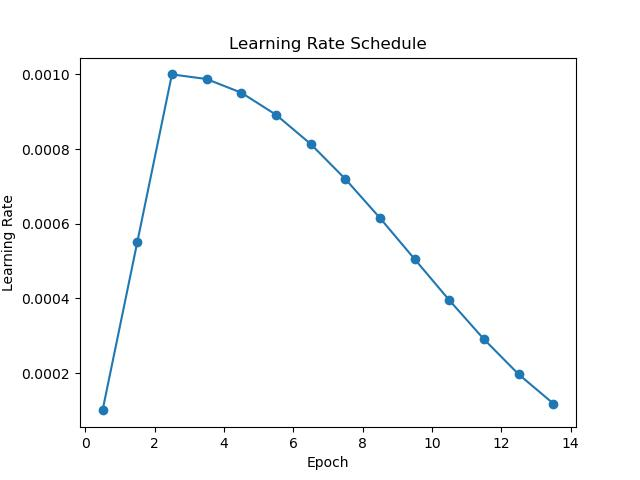

In [26]:
display(Image(filename=paths.train_metric_monitor))

Various performance parameters were monitored during training, on both the training samples and validation. Note that the relatively low scores for training is due to the use of heavy augmentation, and methods like mixup.  The validation samples by contrast were pre-processed in the same way they would be for inference.

- Training began with heavy agumentation, and as it progressed the frequency and magnitude of the augmentation effects were reduced.
- Train/Val Loss |  Focal Loss using binary cross entropy
- cmap5 | macro Average Precision score, but with all classes buffered by 5 true positives, to prevent excessive noise from the rare classes.
- LRAP  | Label Ranced Average Precision Score

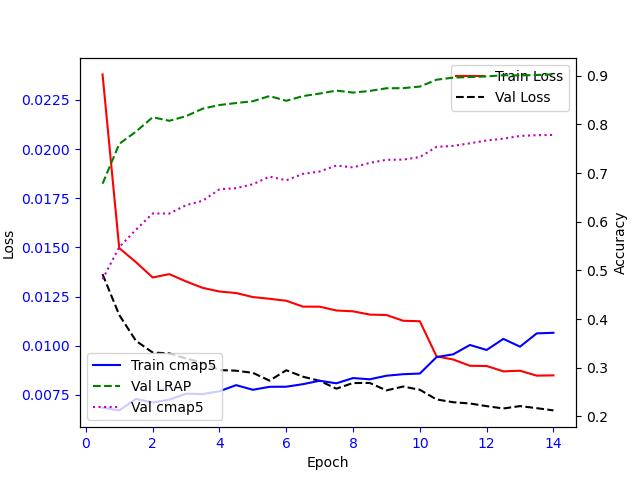

In [27]:
display(Image(filename=paths.learning_rate_monitor))

## Performance on the validation split
- The validation split consists of a random selection of 10% of the audio samples per class, but only for samples where the class had more than 10 samples, otherwise no samples taken.
- For more than half the classes we don't have much data yet.  What data we have comes mostly from a small number of sites and is thus correlated between samples. For those two reasons there isn't much point trying to make a more sophisticated scheme to accurately predict real-life performance.
- So for now I'm just going to make do by looking at the validation set, mainly for classes with more than 50 samples total (so > 5 samples in the validation split).  
- Further development work on training routines will be benchmarked on different datasets from Kenya and India, as these area available on Kaggle.  That will reduce the danger of fitting of the training algorithms to this current New Zealand dataset.
- At the same time work can proceed to improve the size, balance and accuracty of the dataset.
- As more data comes to hand from the rarer classes it will become more meaningful to develop a rigorous test method.

In [28]:
import plotly.express as px
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns


def remove_rare_classes(target_df, pred_df, rare_threshold):
    col_sums = target_df.sum(axis=0)
    original_width = target_df.shape[1]
    mask = col_sums >= rare_threshold

    remove_list=[]
    total_removed = 0
    for column_name, col_sum in col_sums.items():
        if col_sum < rare_threshold:
            remove_list.append((column_name,col_sum))
            total_removed +=col_sum
    
    remove_cols = original_width - mask.sum()
    target_df = target_df.loc[:, mask]
    pred_df = pred_df.loc[:, mask]  

    rows_to_remove = target_df.index[target_df.sum(axis=1) == 0]
    target_df = target_df.drop(rows_to_remove)
    pred_df = pred_df.drop(rows_to_remove)

    rows_with_targets = target_df.any(axis=1)
    target_df = target_df[rows_with_targets]
    pred_df = pred_df[rows_with_targets]

    if remove_cols > 0:
        #print(f'From counting loop: Removing {len(remove_list)} species, {total_removed} instances')  #
        print(f'Removing {remove_cols} classes as they have less than {rare_threshold} samples')
        print(f'Also removing {len(rows_to_remove)} image instances, as they were from those classes')
    return target_df, pred_df


def get_map_score(target_df, pred_df, average='macro'):
    target_df, pred_df = remove_rare_classes(target_df, pred_df, 1)
    col_sums = target_df.sum()
    mask = col_sums >= 1 #keeping this in to avoid division by 0
    targs_arr = target_df.loc[:,mask].copy().values
    preds_arr = pred_df.loc[:,mask].copy().values
    if average is None:
        scores_vals = average_precision_score(targs_arr,preds_arr, average=None)
        if isinstance(scores_vals, float): #handle the situation where only one species is present
            scores_vals = [scores_vals]  
        scores_keys = target_df.columns[mask].tolist()
        scores_dict = {k:v for (k,v) in zip(scores_keys, scores_vals)}
    else:
        scores_dict = {'mean': average_precision_score(targs_arr,preds_arr, average=average)}   
    return scores_dict


def plot_map_by_class(df_target, df_pred, min_samples=5, height=1200):
    df_target, df_pred = remove_rare_classes(df_target, df_pred, min_samples)
    map_dict = get_map_score(df_target, df_pred, average=None)
    col_sums = df_target.sum()
    sorted_cols = col_sums.sort_values(ascending=False)
    names = [name for name in sorted_cols.index]
    counts = [count for count in sorted_cols]
    scores = [map_dict[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], range_x=[0, 1])
    fig.update_layout(height=height, title='Average Precision Score by Species')
    fig.show()
    return names, scores


def get_ba_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return balanced_accuracy_score(target_arr, preds_arr)


def get_accuracy_score(targets_df, preds_df, normalize=True):
    targets_df, preds_df = remove_rare_classes(targets_df, preds_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(preds_df.values, axis=1)
    return skm.accuracy_score(target_arr,  preds_arr, normalize=normalize, sample_weight=None)


def get_f1_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return skm.f1_score(target_arr, preds_arr, pos_label=1, average='macro', zero_division=np.nan)


def get_metrics(targets, predictions, min_freq=5):
    targets, predictions = remove_rare_classes(targets, predictions, min_freq)
    balanced_accuracy = get_ba_score(targets, predictions)
    overall_accuracy = get_accuracy_score(targets, predictions)
    map_scores = get_map_score(targets, predictions)['mean']  #for some reason, this can only run once
    f1_score = get_f1_score(targets, predictions)

    print(Colour.S + f'Overall accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{overall_accuracy:.3f}')
    print(Colour.S + f'Balanced accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{balanced_accuracy:.3f}')
    print(Colour.S + f'macro Average Precision Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{map_scores:.3f}')
    print(Colour.S + f'macro F1 Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{f1_score:.3f}')
    return overall_accuracy, balanced_accuracy, map_scores, f1_score


def build_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=None,
                    cf_pth=None,
                    cf_fig_pth=None,
                    ):
    #targ_df, pred_df = remove_rare_classes(targ_df, pred_df, 1)
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_by_row = np.argmax(target_arr, axis=1)
    predict_by_row = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    target_names = [cols[idx] for idx in target_by_row]
    predict_names = [cols[idx] for idx in predict_by_row]
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_names, predict_names)
    cf_matrix_norm = confusion_matrix(target_names, predict_names, normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f')  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)
    return


def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()


def plot_two_distributions(dist1, 
                           dist2, 
                           label1='Distribution 1', 
                           label2='Distribution 2', 
                           x_max=None, 
                           y_max=None,
                           bins=None):
    
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(dist1, bins=bins, kde=False, color='blue', label=label1, stat='density')
    sns.histplot(dist2, bins=bins, kde=False, color='orange', label=label2, stat='density', ax=ax)
    plt.title(f'{label1} and {label2} score distributions')
    plt.xlabel('Value')
    ax.set(xlim=(0, x_max) if x_max is not None else None)
    ax.set(ylim=(0, y_max) if y_max is not None else None)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [29]:
df_val_pred = pd.read_pickle(paths.val_preds)
df_val_true = pd.read_pickle(paths.val_targs)
eNames = list(df_val_pred.columns)
common_names  = birdnames.common_names(eNames)
df_val_pred.columns = pd.Index(common_names)
df_val_true.columns = pd.Index(common_names)
df_val_pred.head(3)

,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,California Quail,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,0.000008,0.000472,0.001429,0.000001,0.000092,0.000013,0.000062,0.000015,0.000472,0.000031,...,0.289863,0.079275,0.003474,0.000024,0.006803,0.000809,0.158668,0.000027,0.004381,0.215433
1,0.000292,0.003120,0.009671,0.000018,0.001760,0.000023,0.000747,0.000046,0.001886,0.000223,...,0.314253,0.066228,0.010746,0.000061,0.019056,0.000606,0.039831,0.000186,0.020068,0.173615
2,0.000167,0.014495,0.017273,0.000035,0.000437,0.000168,0.027254,0.000181,0.002133,0.003578,...,0.168280,0.082957,0.023145,0.000367,0.029648,0.002077,0.106376,0.009149,0.043257,0.007595


In [30]:
df_val_true.head(3)

,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,California Quail,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's switch to common names to make this easier to interpret.

In [31]:
if (df_val_pred.shape[0] == df_val_true.shape[0]) and (df_val_pred.shape[0] >=20):
    _, _ = plot_map_by_class(df_val_true, df_val_pred, min_samples=5)
else: print(f'There were only {df_val_pred.shape[0]} rows in the predictions dataframe, too few for mAP scores')

Removing 30 classes as they have less than 5 samples
Also removing 23 image instances, as they were from those classes


- There is a pretty obvious and unsurprising trend here.  The birds with more samples have much more consistent performance.  
- Anything with less than 5 validation samples (50 samples in total) were not plotted here, as the score would have little meaning.

How about the distribution of the predictions scores?  Let's look at this and decide on suitable thresholds for presence/absence

In [32]:
df_val_true, df_val_pred = remove_rare_classes(df_val_true, df_val_pred, 5)
print(f'The reduced dataframe has shape {df_val_true.shape}')

Removing 30 classes as they have less than 5 samples
Also removing 23 image instances, as they were from those classes
The reduced dataframe has shape (27847, 57)


In [33]:
pred_vals = df_val_pred.values
targ_vals = df_val_true.values
tp_scores = (pred_vals * targ_vals).flatten()
tn_scores = (pred_vals * (1-targ_vals)).flatten()
tp_scores= tp_scores[tp_scores != 0]
tn_scores= tn_scores[tn_scores != 0]
print(Colour.S + 'The mean prediction value for true positives is: ' + Colour.E + f'{tp_scores.mean():.2}')
print(Colour.S + 'The mean prediction value for true positives is: ' + Colour.E + f'{tn_scores.mean():.2}')

The mean prediction value for true positives is: 0.5
The mean prediction value for true positives is: 0.037


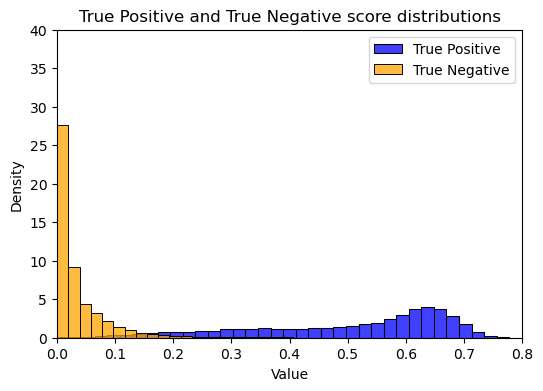

In [34]:
plot_two_distributions(tp_scores, tn_scores, label1='True Positive', label2='True Negative', bins=40, x_max=0.8, y_max=40)

Taking a closer look at the true positives

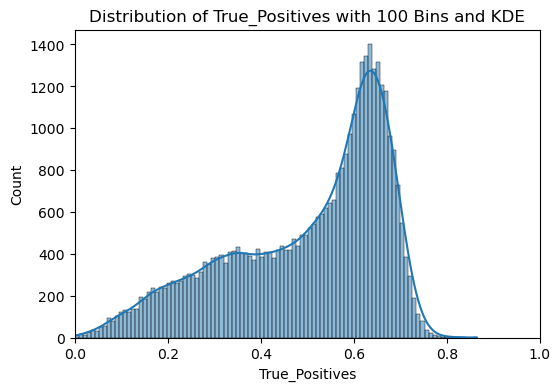

In [35]:
plot_continuous(pd.DataFrame(tp_scores, columns=['True_Positives']), 'True_Positives', x_min=0, x_max=1, bins=100)

A perfect classifier would have no overlap between these distributions.  In our case, the overlap is small, and we would have virtually no false negatives with a threshold of 0.2, and a few false positives.   Let's set a threshold of 0.2 and see what performance we get from some practical use metrics.

In [36]:
threshold = 0.2
pred_vals_binary = (pred_vals > threshold).astype(int)

In [37]:
targets = list(df_val_pred.columns)
scores_dict = classification_report(targ_vals, pred_vals_binary, target_names=targets, digits=2, output_dict=True, zero_division=1)
df_scores = pd.DataFrame.from_dict(scores_dict, orient='index')

df_scores.tail(4)

,precision,recall,f1-score,support
micro avg,0.496483,0.929757,0.647308,39093.0
macro avg,0.457052,0.701998,0.523311,39093.0
weighted avg,0.518480,0.929757,0.658203,39093.0
samples avg,0.611216,0.945108,0.703146,39093.0


In [38]:
pd.set_option('display.max_rows', 60)
df_scores.head(57)

,precision,recall,f1-score,support
Australasian Bittern,0.444444,0.444444,0.444444,9.0
Australian Magpie,0.396226,0.636364,0.488372,33.0
New Zealand Pipit,0.383929,0.914894,0.540881,47.0
Black-fronted Tern,0.571429,0.800000,0.666667,5.0
Black Swan,0.120000,0.500000,0.193548,6.0
California Quail,0.285714,0.400000,0.333333,5.0
Canada Goose,0.369565,0.739130,0.492754,23.0
Chaffinch,0.470765,0.881033,0.613641,1782.0
Indian Myna,0.200000,0.090909,0.125000,11.0
Redpoll,0.428571,0.814655,0.561664,232.0


In [39]:
df_val_pred_binary = pd.DataFrame(data=pred_vals_binary, columns=targets)
df_val_pred_binary.shape

(27847, 57)

In [ ]:
df_val_pred_binary

In [40]:
df_val_true.shape

(27847, 57)

###  Sort this out by class size!!!

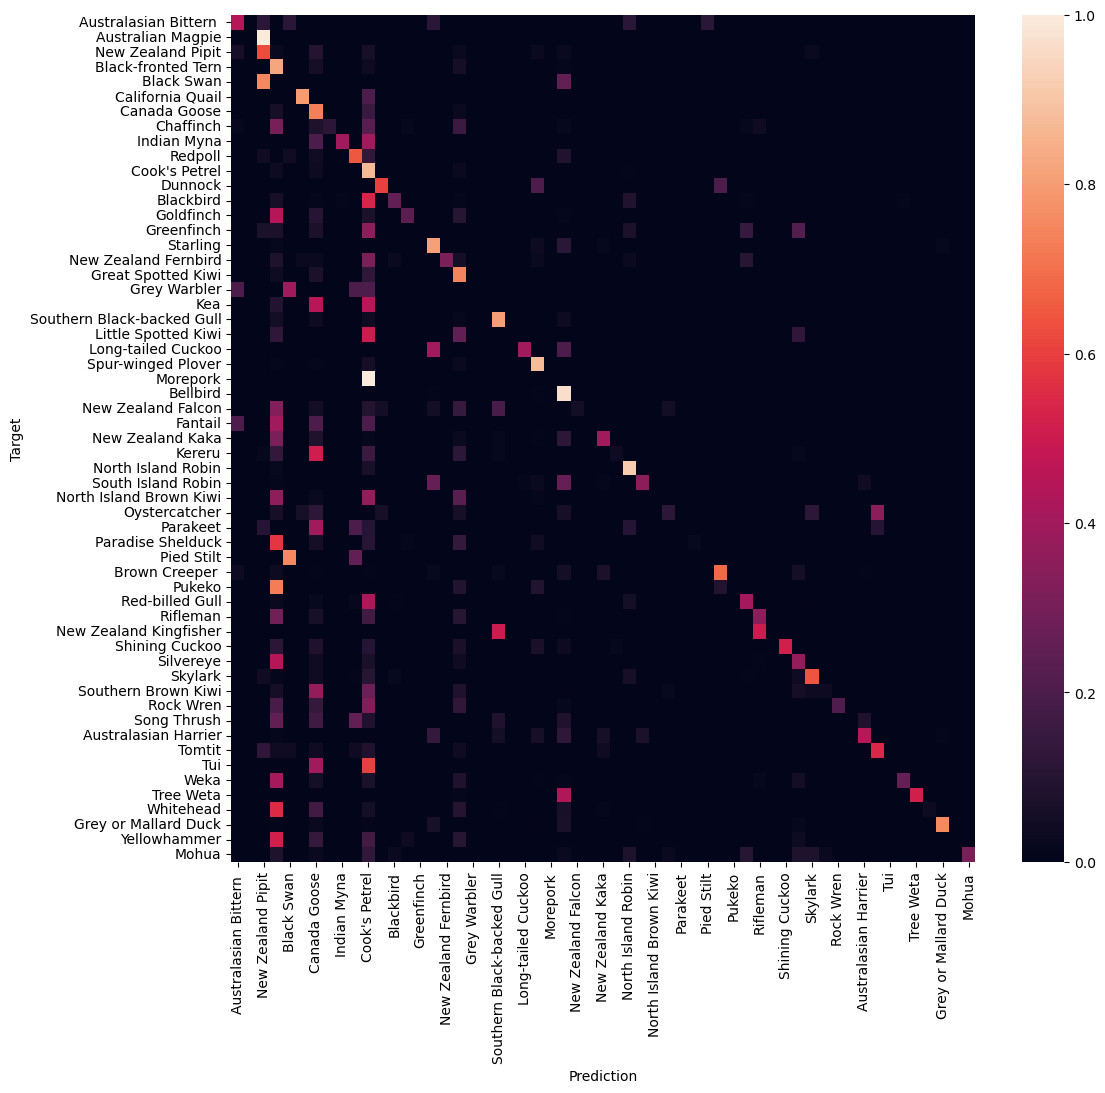

In [41]:
build_cf_matrix(df_val_true, df_val_pred_binary)

## Performance with reduced classes

Merging similar sounding classses could help in a couple of ways:
- We get a more meaningful number of validation results
- Errors between those species are eliminated.  In most cases this will be of little practical consequence, as the species can be delineated by their locations.

In [42]:
df_val_pred = pd.read_pickle(paths.val_preds)
df_val_true = pd.read_pickle(paths.val_targs)
df_val_true, df_val_pred = remove_rare_classes(df_val_true, df_val_pred, 5)
eNames = list(df_val_pred.columns)
extra_names  = birdnames.extra_names(eNames)
preds_binary = (df_val_pred.values > threshold).astype(int)
df_binary = pd.DataFrame(preds_binary, columns=df_val_true.columns)
df_binary.head(3)

Removing 30 classes as they have less than 5 samples
Also removing 23 image instances, as they were from those classes


,ausbit1,ausmag2,auspip3,blfter1,blkswa,calqua,cangoo,comcha,commyn,comred,...,sonthr1,swahar1,tomtit1,tui1,weka1,weta,whiteh1,x00458,yellow2,yellow3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
name_df = pd.DataFrame({'ebirds': eNames, 'extra_name': extra_names})
mergers = name_df.groupby('extra_name').agg({'ebirds': list})
merger_dict = mergers['ebirds'].to_dict()
print(mergers[mergers['ebirds'].apply(len) > 1])
print(Colour.S + '\nThe number of unique classes will be reduced to:' + Colour.E, f'{len(set(extra_names))}')

                                 ebirds
extra_name                             
Brown Kiwi           [nibkiw1, sobkiw2]
Cuckoo               [lotkoe1, shbcuc1]
Finch         [comcha, eurgol, eurgre1]
Gull                  [kelgul, rebgul1]
Robin                [nezrob2, nezrob3]
Spotted Kiwi         [grskiw1, liskiw1]

The number of unique classes will be reduced to: 50


In [44]:
merged_preds = {}
merged_targs = {}
for name in mergers.index.to_list():
    merging_cols = merger_dict[name]
    merging_pred_vals = df_binary[merging_cols].values
    merging_targ_vals = df_val_true[merging_cols].values
    merged_preds[name] = np.any(merging_pred_vals, axis=1).astype(int)
    merged_targs[name] = np.any(merging_targ_vals, axis=1).astype(int)

In [45]:
merged_preds['Brown Kiwi']

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
merged_pred_df = pd.DataFrame(merged_preds)
merged_targ_df = pd.DataFrame(merged_targs)
merged_pred_df.head()

,Bellbird,Bittern,Blackbird,Brown Kiwi,Creeper,Cuckoo,Duck,Dunnock,Falcon,Fantail,...,Tern,Thrush,Tomtit,Tui,Warbler,Weka,Weta,Whitehead,Wren,Yellowhammer
0,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [58]:
targets = list(merged_pred_df.columns)
scores_dict = classification_report(merged_targ_df.values, merged_pred_df.values, target_names=targets, digits=2, output_dict=True, zero_division=1)
df_merged_scores = pd.DataFrame.from_dict(scores_dict, orient='index')
df_merged_summary = df_merged_scores.tail(4)
df_merged_scores = df_merged_scores.head(-4).sort_values(by='support',  ascending=False)
df_merged_summary

,precision,recall,f1-score,support
micro avg,0.499677,0.931214,0.650373,39078.0
macro avg,0.467887,0.711049,0.530955,39078.0
weighted avg,0.521772,0.931214,0.661240,39078.0
samples avg,0.613392,0.946275,0.705195,39078.0


In [59]:
df_merged_scores

,precision,recall,f1-score,support
Bellbird,0.533191,0.981521,0.691007,8388.0
Tomtit,0.417962,0.974741,0.585056,6374.0
Silvereye,0.449081,0.943781,0.608580,4607.0
Morepork,0.817888,0.989255,0.895447,4095.0
Warbler,0.531620,0.902846,0.669198,2635.0
Finch,0.481921,0.877496,0.622154,1853.0
Blackbird,0.427895,0.865269,0.572617,1670.0
Tui,0.364750,0.827512,0.506324,1403.0
Kaka,0.578366,0.898029,0.703592,1167.0
Rifleman,0.440453,0.926501,0.597065,966.0


Looking specifically at the classes that were effected by the merger

In [50]:
merger_list = mergers[mergers['ebirds'].apply(len) > 1].index.tolist()
df_merged_scores.loc[merger_list]

,precision,recall,f1-score,support
Brown Kiwi,0.557823,0.735426,0.634429,223.0
Cuckoo,0.721530,0.950762,0.820435,853.0
Finch,0.481921,0.877496,0.622154,1853.0
Gull,0.363636,0.551724,0.438356,29.0
Robin,0.522196,0.848197,0.646421,527.0
Spotted Kiwi,0.459821,0.804688,0.585227,128.0


In [51]:
ebird_list = mergers[mergers['ebirds'].apply(len) > 1]['ebirds'].to_list()
ebird_list = [item for sublist in ebird_list for item in sublist]
common_list = birdnames.common_names(ebird_list)
df_scores.loc[common_list]

,precision,recall,f1-score,support
North Island Brown Kiwi,0.488636,0.614286,0.544304,70.0
Southern Brown Kiwi,0.406475,0.738562,0.524362,153.0
Long-tailed Cuckoo,0.713178,0.959583,0.818232,767.0
Shining Cuckoo,0.710000,0.825581,0.763441,86.0
Chaffinch,0.470765,0.881033,0.613641,1782.0
Goldfinch,0.160000,0.285714,0.205128,28.0
Greenfinch,0.371681,0.736842,0.494118,57.0
Southern Black-backed Gull,0.125000,0.230769,0.162162,13.0
Red-billed Gull,0.600000,0.750000,0.666667,16.0
North Island Robin,0.374101,0.787879,0.507317,264.0


- The mergers helped  with Brown Kiwi, Spotted Kiwi, Robin, Finch, & Cuckoo
- They did not appear not helpful for Gull, but with very small sample sizes

Perhaps this idea needs to be handled on a case by case basis, as we learn more about which birds can be realisticaly distinguished by the model and/or the labelling humans.

In [54]:
#build_cf_matrix(df_val_true, df_val_pred_binary)